In [6]:
import torch
from a_priori_snr.models.a_priori_snr_tcn import APrioriSNREstimator
from pathlib import Path
import torchaudio as ta
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_ESTIMATING_ALL_FREQS = False
if MODEL_ESTIMATING_ALL_FREQS:
    checkpoint_path = Path(
    "/home/marvint/dr/code/deep_learning_projects/a-priori-snr-estimator/a_priori_snr/saved/20240524_171010_crazy-block-70/epoch=81-step=738000.ckpt",   # all freqs
    )
else:
    checkpoint_path = Path(
    "/home/marvint/dr/code/deep_learning_projects/a-priori-snr-estimator/a_priori_snr/saved/20240524_171010_actual-consequence-88/epoch=57-step=522000.ckpt"  # only three freqs
    )

In [7]:
wav_file_path = Path('realrec_english_wer_Headphones_HeavyBreathing_A317RA15E0SZ4P_113.wav')

model = APrioriSNREstimator.load_from_checkpoint(
    checkpoint_path,
    map_location=device,
)
model.eval()  # put into evaluation mode (batch normalization handled differently)

wav_data, fs_wav = ta.load(wav_file_path)
if wav_data.shape[0] > 1:  # use single channel
    wav_data = wav_data[:1]
wav_data = wav_data.to(device=device)
if fs_wav != model.fs:
    wav_data = ta.functional.resample(wav_data, orig_freq=fs_wav, new_freq=model.fs)

wav_data = wav_data.unsqueeze(0)
display(wav_data.shape)
inp = {
    "input": wav_data,
}

using only following freqs in loss computation: tensor([1250., 2250., 3500.])
receptive field: 1531 time steps


torch.Size([1, 1, 176960])

In [8]:
# play sound
display(Audio(wav_data[0].cpu().numpy(), rate=model.fs))

In [9]:
with torch.no_grad():  # no gradient computation needed for inference
    a_priori_snr_estimate = model.perform_inference(inp)[0]

noisy_periodogram = (
    model.stft.get_stft(wav_data).abs().pow(2).cpu().numpy().squeeze(0).squeeze(0)
)
# if not MODEL_ESTIMATING_ALL_FREQS:
#     noisy_periodogram = noisy_periodogram[model.freq_indices, :]

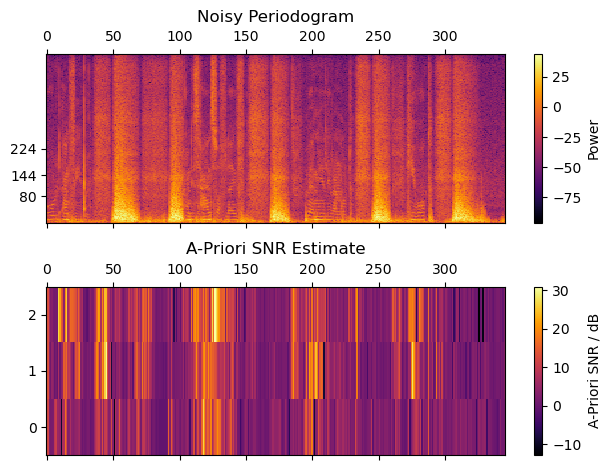

In [12]:
# plot noisy periodogram and a-priori SNR
fig, ax = plt.subplots(2, 1)
im1 = ax[0].matshow(
    10 * np.log10(noisy_periodogram), origin="lower", aspect="auto", cmap="inferno"
)
if not MODEL_ESTIMATING_ALL_FREQS:
    # mark the three frequencies that are estimated (model.freq_indices) on the left side of the y axis
    ax[0].set_yticks(model.freq_indices)
ax[0].set_title("Noisy Periodogram")
im2 = ax[1].matshow(
    (10 * a_priori_snr_estimate.log10()).cpu().numpy(),
    origin="lower",
    aspect="auto",
    cmap="inferno",
)
ax[1].set_title("A-Priori SNR Estimate")

cbar1 = fig.colorbar(im1, ax=ax[0])
cbar1.set_label("Power")
cbar2 = fig.colorbar(im2, ax=ax[1])
cbar2.set_label("A-Priori SNR / dB")

plt.tight_layout()
fig.show()